<a href="https://colab.research.google.com/github/renato-evangelista/previsao_time_series/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Intro

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

## 0.1. Helper Func

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(12, 6))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

<ipython-input-25-f1605b77a1ec>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## 0.2. Imports

In [ ]:
# imports colab
from google.colab import drive
drive.mount("/content/drive")

df_train    = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/train.csv')
df_test     = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/test.csv')
df_oil      = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/oil.csv')
df_holidays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/holidays_events.csv')
df_stores   = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/stores.csv')
df_transactions   = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/transactions.csv')

# imports kaggle
# df_train    = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
# df_test     = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
# df_oil      = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
# df_holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
# df_stores   = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
# df_transactions   = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')


print(f'Number of Training Examples = {df_train.shape[0]}')
print(f'Number of Test Examples = {df_test.shape[0]}\n')
print(f'Training X Shape = {df_train.shape}')
print(f'Training y Shape = {df_train.shape[0]}\n')
print(f'Test X Shape = {df_test.shape}')
print(f'Test y Shape = {df_test.shape[0]}\n')

print(df_train.columns)
print(df_test.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of Training Examples = 3000888
Number of Test Examples = 28512

Training X Shape = (3000888, 6)
Training y Shape = 3000888

Test X Shape = (28512, 5)
Test y Shape = 28512

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')


# 1.0. EDA

In [ ]:
df = df_train.copy()
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


Text(0.5, 1.0, 'Family')

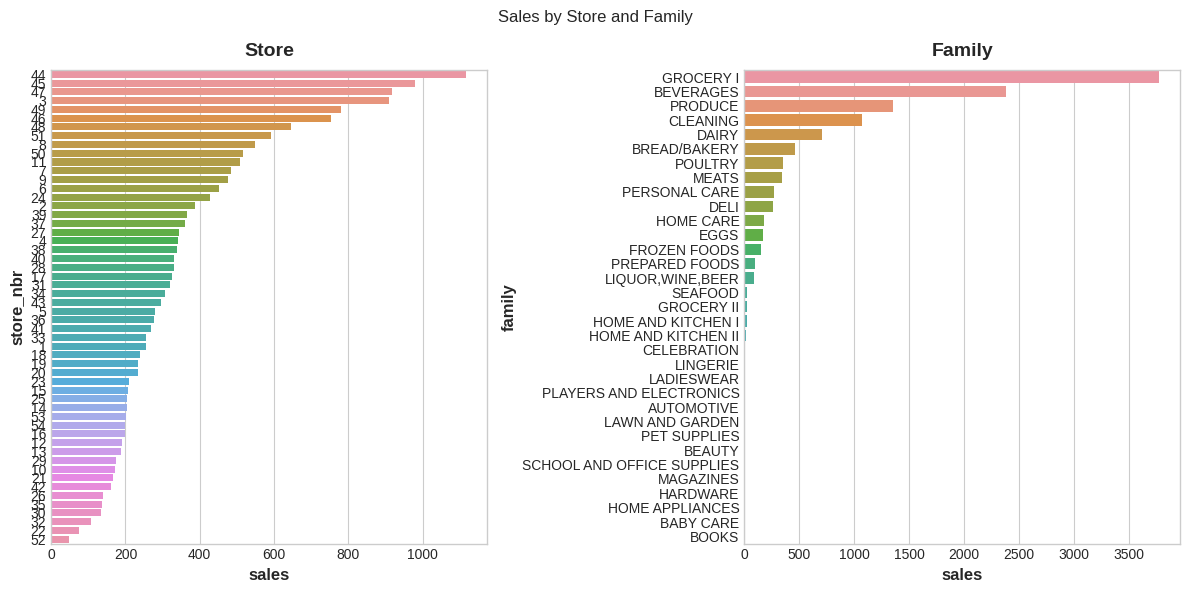

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.suptitle('Sales by Store and Family')

# store
grouped = df.loc[:, ['store_nbr', 'sales']].groupby('store_nbr').mean()

# plot
sns.barplot(ax=axes[0], data=grouped, x='sales', y=grouped.index, orient='h', order=grouped.sort_values('sales', ascending=False).index);
axes[0].set_title('Store')

# family
grouped2 = df.loc[:, ['family', 'sales']].groupby('family').mean()

# plot
sns.barplot(ax=axes[1], data=grouped2, x='sales', y=grouped2.index, orient='h', order=grouped2.sort_values('sales', ascending=False).index);
axes[1].set_title('Family')

# 2.0. Time-step and lag features

In [1]:
# Average daily sales

df1 = df[['date', 'sales']].groupby('date').mean()

NameError: ignored

In [ ]:
# Time-step feature
df1['time'] = np.arange(len(df1.index))
df1.head()

In [ ]:
# Training data
X = df1.loc[:, ['time']]  # features
y = df1.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Average Daily Sales');

In [ ]:
# lag feature
df1['lag'] = df1['sales'].shift(1)
df1.head()

In [ ]:
X = df1.loc[:, ['lag']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df1.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['lag'], y, '.', color='0.25')
ax.plot(X['lag'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('sales')
ax.set_xlabel('lag')
ax.set_title('Lag Plot of Sales');

In [ ]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

# 3.0. Trend

In [ ]:
# Average daily sales
df2 = df_train.copy()
df2 = df[['date', 'sales']].groupby('date').mean()

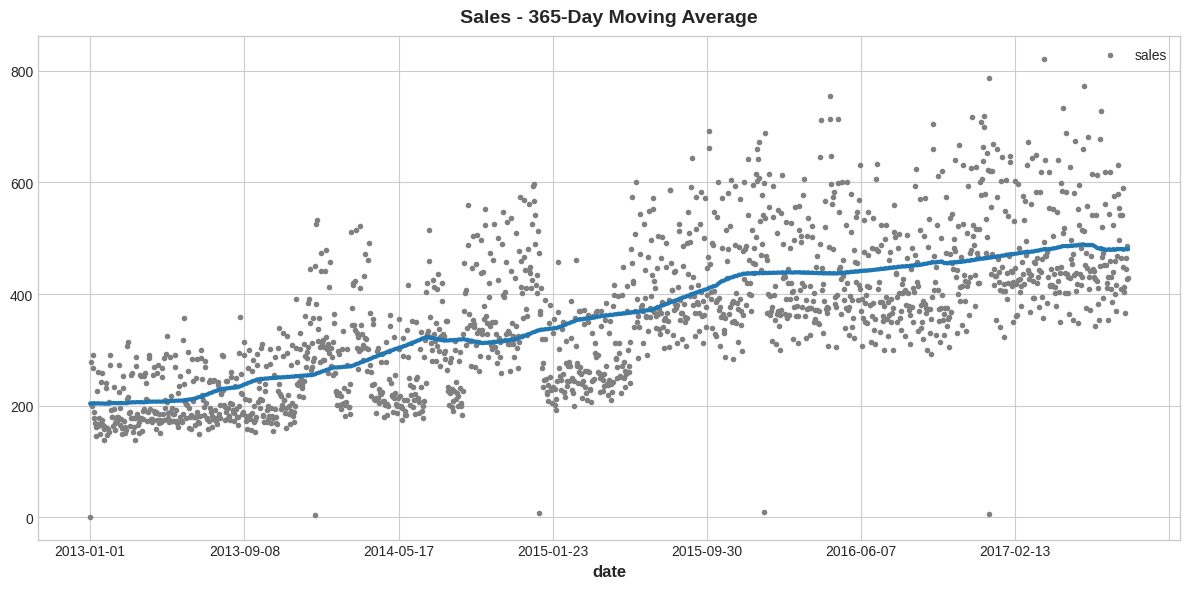

In [ ]:
moving_average = df2.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df2.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

In [ ]:
# time-step (dummy) feature

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=df2.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.00,1.00
2013-01-02,1.00,2.00
2013-01-03,1.00,3.00
2013-01-04,1.00,4.00
2013-01-05,1.00,5.00


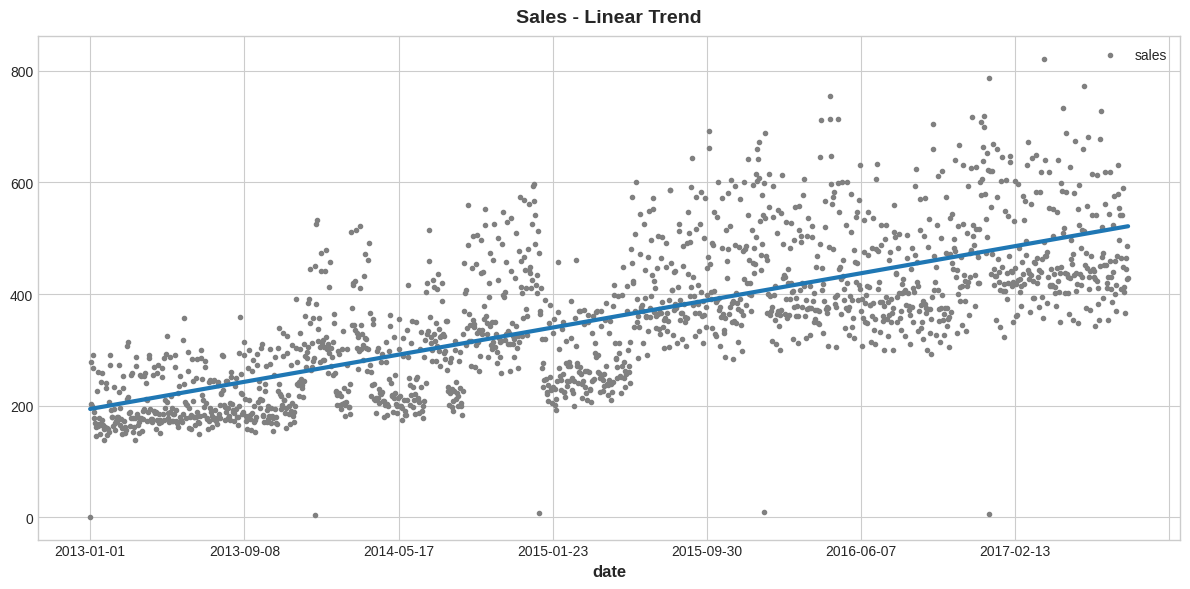

In [ ]:
y = df2["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

# Plot
ax = df2.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


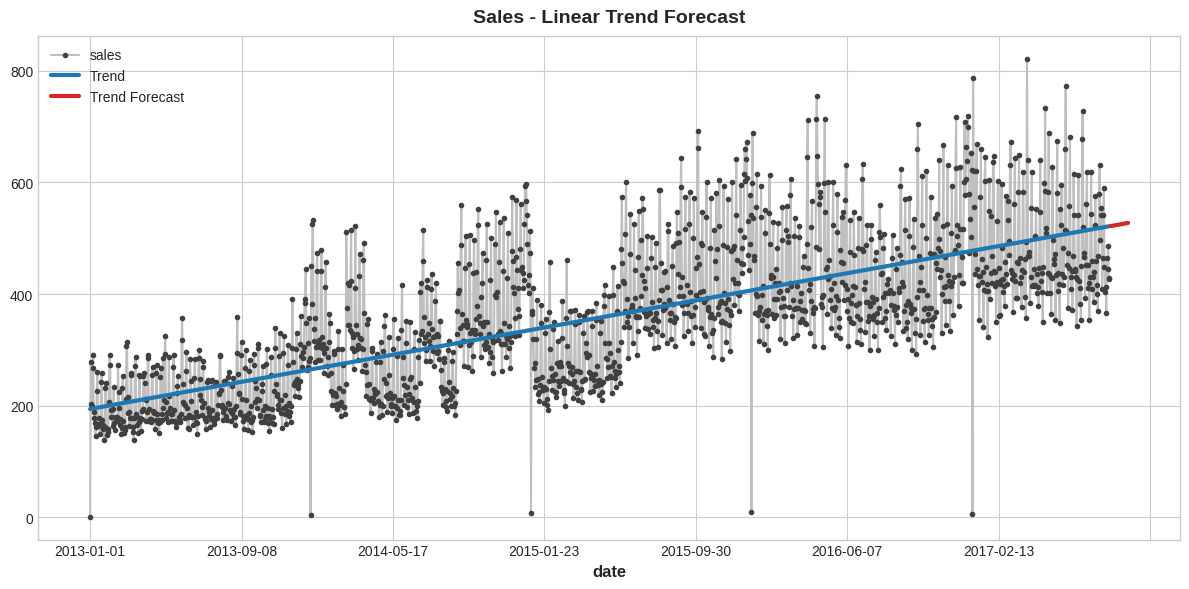

In [ ]:
# Model
X = dp.out_of_sample(steps=30)
y_fore = pd.Series(model.predict(X), index=X.index)

# Plot
ax = df2["2013-01":].plot(title="Sales - Linear Trend Forecast", **plot_params)
ax = y_pred["2013-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# 4.0. Seasonality

In [ ]:
# Average daily sales
df3 = df_train.copy()
df3 = df3[['date', 'sales']].groupby('date').mean()
df3.index = pd.to_datetime(df3.index)
df3.head()

,sales
date,
2013-01-01,1.41
2013-01-02,278.39
2013-01-03,202.84
2013-01-04,198.91
2013-01-05,267.87


<ipython-input-41-8faf086a960e>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week  # the seasonal period (period)
<ipython-input-25-f1605b77a1ec>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
<ipython-input-25-f1605b77a1ec>:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


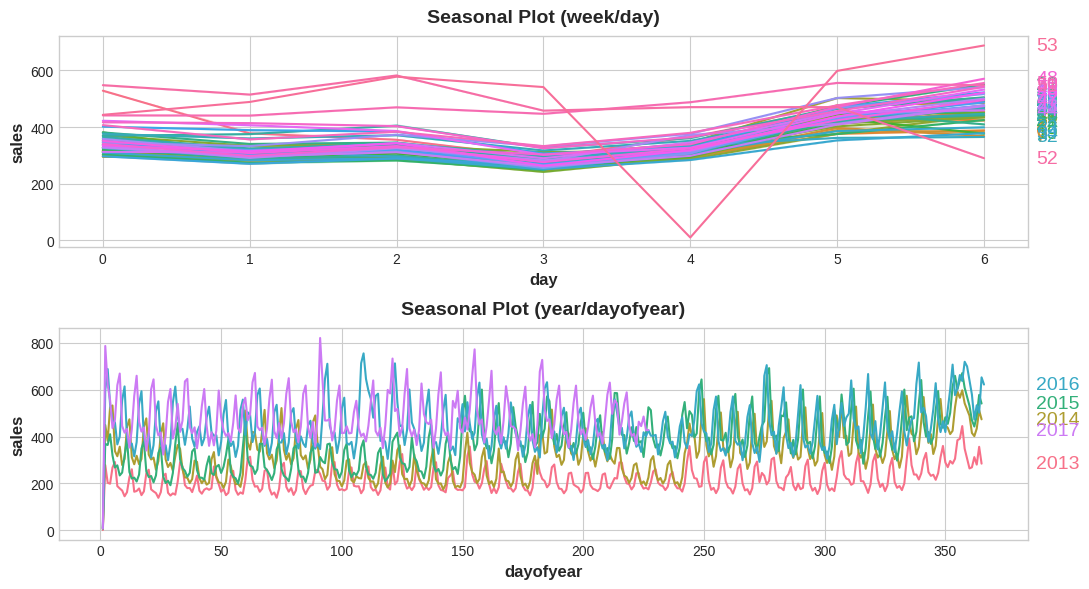

In [ ]:
X = df3.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6));
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0);
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

<ipython-input-25-f1605b77a1ec>:55: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


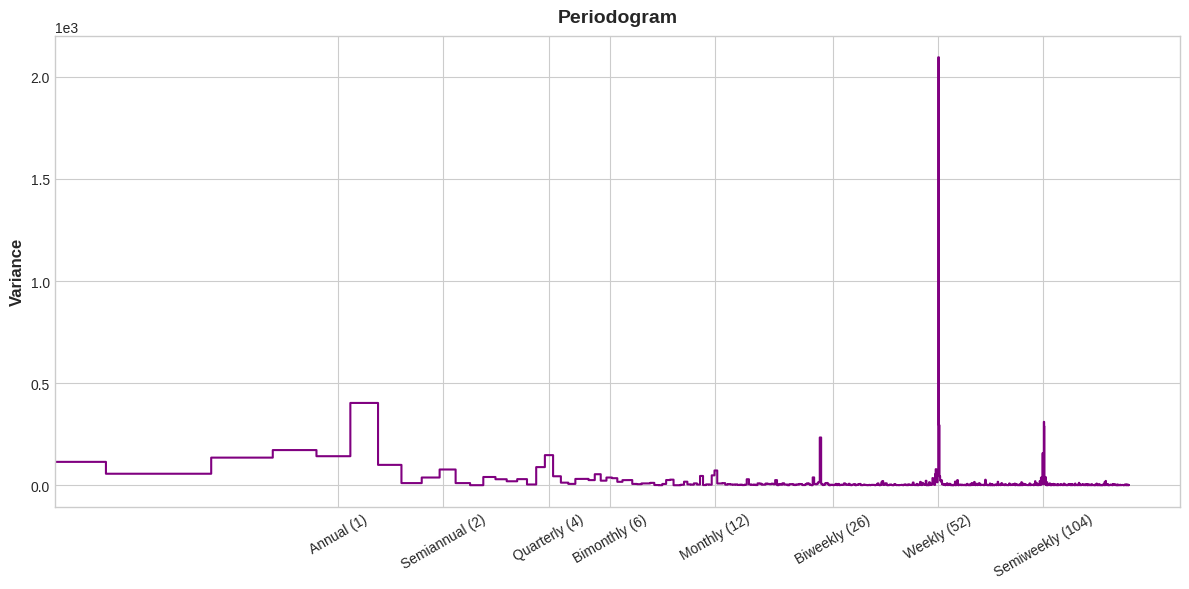

In [ ]:
plot_periodogram(df3.sales);

In [ ]:
df3 = df3.reset_index().set_index('date').to_period("D")

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=df3.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

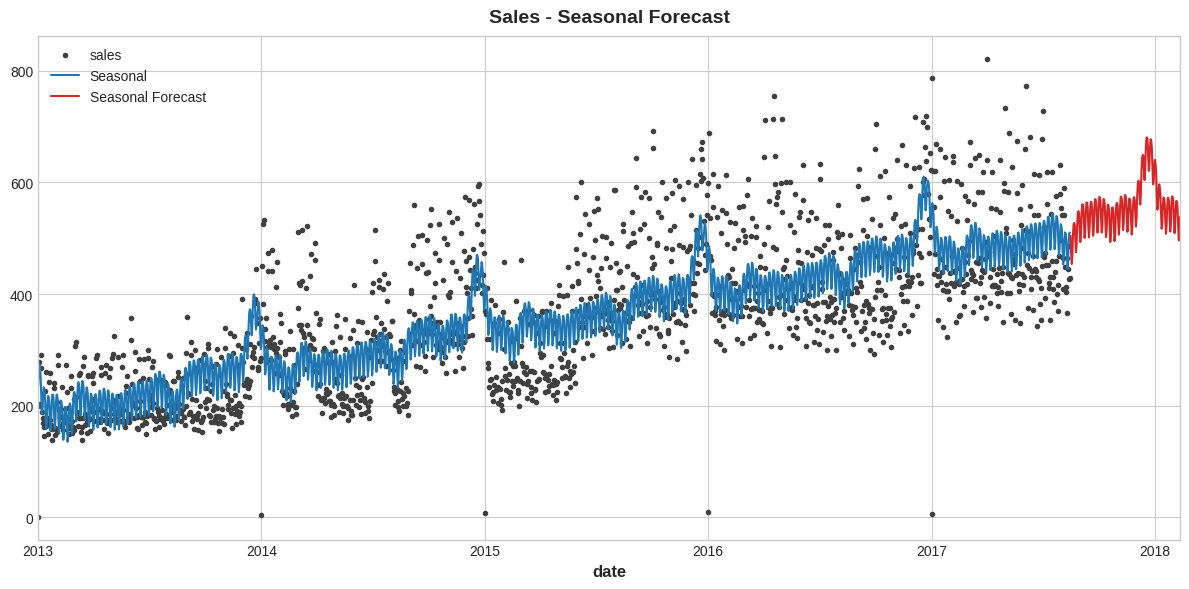

In [ ]:
y = df3["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=180)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [ ]:
store_sales = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


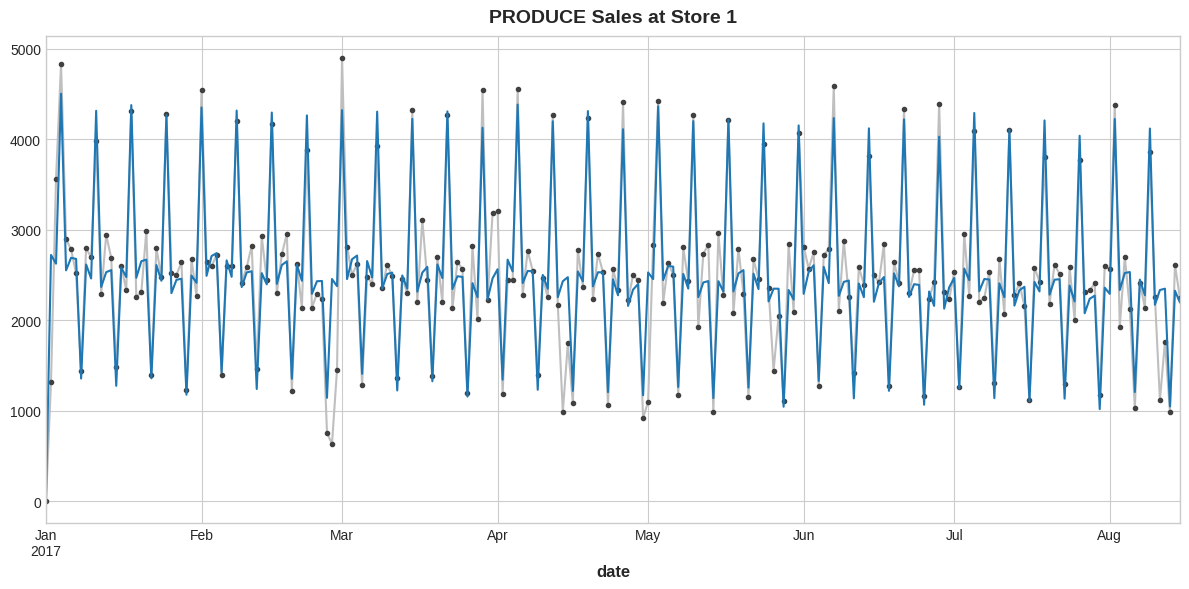

In [ ]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [ ]:
df_test = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/data/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/store_sales_time_series/output/submission2.csv', index=False)